<a href="https://colab.research.google.com/github/gabrielsluz/8PuzzleAI/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduação à Computação Visual - TP3

**Nome:** Alan Prado Araújo **Matrícula:** 2017015037

**Nome:** Gabriel Santos Luz **Matrícula:** 2017015126

Colab setup

In [1]:
#Usando google drive para rodar notebook no colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
%cp -r /content/drive/My\ Drive/dados.zip /content/
!unzip dados.zip

Fim colab setup

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
CHAR_IMAGE_HEIGHT = 30
CHAR_IMAGE_WIDTH = 34
CAPTCHA_NUMBER_OF_CHARS = 6

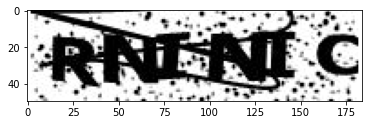

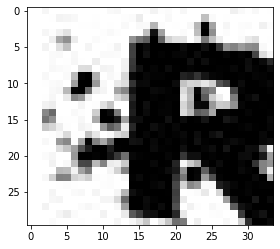

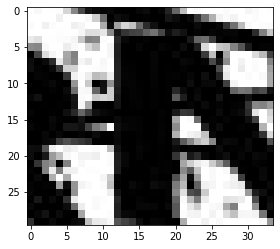

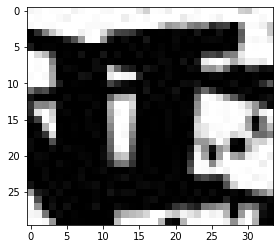

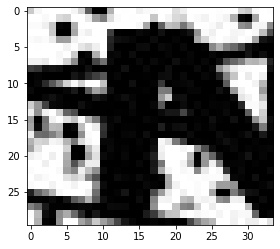

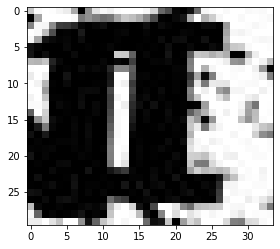

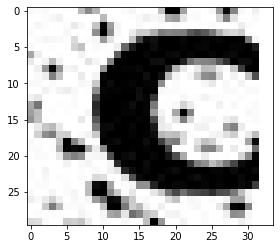

(6120,)


In [5]:
def calculatePadding(oldLength, newLength):
    padding = int((newLength - oldLength)/ 2)
    if padding <= 0:
        padding = 0
    return padding

def appendCropImages(cropList, img, cropHeight, cropWidth, cropNumber = CAPTCHA_NUMBER_OF_CHARS, verbose = False):
    expectedCropWidth = img.shape[1] / cropNumber
    paddingX = calculatePadding(expectedCropWidth, cropWidth)
    paddingY = calculatePadding(img.shape[0], cropHeight)
    img = cv2.copyMakeBorder(img, paddingY, paddingY, paddingX, paddingX, cv2.BORDER_CONSTANT, value=255)
    
    if verbose:
        plt.imshow(img, cmap = 'gray')
        plt.show()
    
    cropCenterXList = np.empty([cropNumber]) 
    for i in range(cropNumber):
        cropCenterXList[i] = int(paddingX + expectedCropWidth / 2 + expectedCropWidth * i)
    cropCenterY = paddingY + img.shape[0] / 2 
    
    cropHeightHalf = cropHeight / 2
    top = int(cropCenterY - cropHeightHalf)
    bottom = int(cropCenterY + cropHeightHalf)
    for i in range(cropNumber):
        cropWidthHalf = cropWidth / 2
        left = int(cropCenterXList[i] - cropWidthHalf)
        right = int(cropCenterXList[i] + cropWidthHalf)
        crop = img[top:bottom, left:right]
        cropList = np.append(cropList, crop)
        if verbose:
            plt.imshow(crop, cmap = 'gray')
            plt.show()
    return cropList
        
img = cv2.imread('dados/CAPTCHA-10k/treinamento/000001.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cropList = np.array([])
cropList = appendCropImages(cropList, img_gray, CHAR_IMAGE_HEIGHT, CHAR_IMAGE_WIDTH, verbose = True)
print(cropList.shape)

In [6]:
basePath = 'dados/CAPTCHA-10k/'
labelsRelativePath = 'labels10k/'
trainRelativePath = 'treinamento/'
testRelativePath = 'teste/'
validationRelativePath = 'validacao/'

labelsPath = basePath + labelsRelativePath
trainPath = basePath + trainRelativePath

def createCharDatasetFromDirectory(path, length = 1):
    filesNames = os.listdir(path)
    x = np.array([])
    y = np.array([])
    
    maxLength = len(filesNames)
    if length < 0 or length > maxLength:
        length = maxLength
        
    for i in range(length):
        img = cv2.imread(path + filesNames[i])
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        x = appendCropImages(x, img_gray, CHAR_IMAGE_HEIGHT, CHAR_IMAGE_WIDTH)
        labelFile = open(labelsPath + filesNames[i][:CAPTCHA_NUMBER_OF_CHARS] + '.txt', 'r')
        label = labelFile.read()
        for j in range(CAPTCHA_NUMBER_OF_CHARS):
            y = np.append(y, label[j])
        labelFile.close()
    x = x.reshape((length * CAPTCHA_NUMBER_OF_CHARS, CHAR_IMAGE_HEIGHT, CHAR_IMAGE_WIDTH, 1)).astype('float32')
    #normalization
    x /= 255
    return x, y

trainX, trainY = createCharDatasetFromDirectory(trainPath, 100)
print(trainX.shape)
print(trainY.shape)

validationPath = basePath + validationRelativePath
validationX, validationY = createCharDatasetFromDirectory(validationPath, 20)
print(validationX.shape)
print(validationY.shape)

# validationX = np.array([])
# validationY = np.array([])

(600, 30, 34, 1)
(600,)
(120, 30, 34, 1)
(120,)


In [7]:
'''
Gera vetores one-hot, seguindo a seguinte ordem:
0, ..., 9, A, ..., Z
Ou seja, posição 0 do vetor = caracter 0
e posição 35 do vetor = caracter Z
'''
def label_to_one_hot(label):
    one_hot = np.zeros((36,))
    
    ascii_code = ord(label)
    if ascii_code < 65:
        index = ascii_code - 48
    else:
        index = ascii_code - 55
    one_hot[index] = 1
    return one_hot

def one_hot_dataset(label_array):
    num_labels = label_array.shape[0]
    one_hot_array = np.zeros((num_labels, 36))
    for i in range(num_labels):
        one_hot_array[i] = label_to_one_hot(label_array[i])
    return one_hot_array

In [8]:
trainY_one_hot = one_hot_dataset(trainY)
validationY_one_hot = one_hot_dataset(validationY)
print(trainY_one_hot.shape)
print(validationY_one_hot.shape)

(600, 36)
(120, 36)


### Testes com Keras

In [9]:
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import Adam

def define_model(input_shape, num_classes):
    model = Sequential(
    [
        keras.Input(shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation="relu"),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])
    opt = Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
model = define_model((30, 34, 1), 36)
model.fit(trainX, trainY_one_hot, batch_size=32, epochs=1, validation_data=(validationX, validationY_one_hot))

19/19 [==============================] - 0s 15ms/step - loss: 3.5517 - accuracy: 0.0500 - val_loss: 3.5202 - val_accuracy: 0.0417
